# Genome Functional

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print("Loading datasets...  ", end = "")
gdf = pd.read_csv("/kaggle/input/rice-genotype/dataset/genotype_data/12k_ld_imputed.csv")
tdf = pd.read_csv("/kaggle/input/rice-genotype/dataset/trait_data/quantitative_traits.csv")
gdf = gdf.rename(columns = {gdf.columns[0]: "ID"}).set_index("ID")
tdf = tdf.rename(columns = {tdf.columns[0]: "ID"}).set_index("ID").fillna(method = "ffill")
gdf = gdf[gdf.index.isin(tdf.index.values)]
print(tdf.isna().sum().sum())
print("Done")

enc_map = {0.0: "00", -1.0: "01", 1.0: "10", 2.0: "11"}
loc_map = list(gdf.columns)
enc_op = np.array(list(enc_map.keys()))

flatten = lambda arr: [val for subarr in arr for val in subarr]
take = lambda arr, i: [val[i] for val in arr]
decode = lambda arr: [decode_trait("".join(str(int(round(value))) for value in subarr)) for subarr in arr]
unpack = lambda arr: [list(val.values()) for val in arr]

print("Cleaning up...  ", end = "")
cround = np.vectorize(lambda val: enc_op[np.abs(enc_op - val).argmin()] if val not in enc_op else val)
gdf = pd.DataFrame(cround(gdf.values), columns = gdf.columns, index = gdf.index)
print("Done")

trait_map = {}

print("COLUMN NAME\tMIN\tMAX\tRANGE\tMEAN\n---------------------------------------------")
for column in tdf.columns:
    print(f"{column}     \t{tdf[column].min()}\t{tdf[column].max()}\t{round(tdf[column].max() - tdf[column].min())}\t{round(tdf[column].mean())}")
    
    max_val = math.ceil(tdf[column].max())
    #req_dec = not all(np.mod(x, 1) == 0 for x in tdf[column])
    req_dec = max_val < 15
    if (req_dec): max_val *= 10
    bit_length = round(math.log([n for n in [2**n for n in range(1, 100)] if n > max_val][0], 2))
    trait_map.update({column: {"bits": bit_length, "dec": req_dec}})

def encode_gene(row):
    string = ""
    for value in row:
        string += enc_map[float(value)]
    return string

def decode_gene(b_string):
    gene_map = {}
    for i in range(0, len(string), 2):
        target_encoded = string[i:i + 2]
        gene = list(enc_map.keys())[list(enc_map.values()).index(target_encoded)]
        gene_map.update({loc_map[round(i/2)]: gene})
    return gene_map

def encode_trait(row):
    string = ""
    for column in trait_map.keys():
        bits = trait_map[column]["bits"]
        dec = trait_map[column]["dec"]
        val = round(row[column]*(10 if dec else 1))
        string += "{0:b}".format(val).zfill(bits)
    return string

def decode_trait(b_string):
    dec_map = {}
    p = 0
    for column in trait_map.keys():
        bits = trait_map[column]["bits"]
        dec = trait_map[column]["dec"]
        b_seq = b_string[p:p + bits]
        trait = int(b_seq, 2)/(10 if dec else 1)
        dec_map.update({column: trait})
        p += bits
    return dec_map

def plot_history(epochs, history, accuracy_label):
    plt.title("Training Accuracy and Loss")
    plt.plot(range(epochs), history.history[accuracy_label], label = "Training Accuracy")
    plt.plot(range(epochs), history.history["loss"], label = "Training Loss")
    plt.legend()
    plt.show()

    plt.title("Validation Accuracy and Loss")
    plt.plot(range(epochs), history.history["val_" + accuracy_label], label = "Validation Accuracy")
    plt.plot(range(epochs), history.history["val_loss"], label = "Validation Loss")
    plt.legend()
    plt.show()

master = pd.DataFrame(columns = ["GENE_STRING", "TRAIT_STRING"])

print("Generating master...  ")
for index, row in tqdm(gdf.iterrows(), total = gdf.shape[0]):
    master.loc[index] = [encode_gene(row), encode_trait(tdf.loc[index])]
print("Done")

print(master.head())

print("Generating samples...")
b_inputs = master["GENE_STRING"].tolist()
b_outputs = master["TRAIT_STRING"].tolist()
print(f"{len(b_inputs)} input samples, {len(b_outputs)} output samples")

/kaggle/input/rice-genotype/dataset/genotype_data/12k_ld_imputed.csv
/kaggle/input/rice-genotype/dataset/genotype_data/12k_unimputed.csv
/kaggle/input/rice-genotype/dataset/trait_data/readme.txt
/kaggle/input/rice-genotype/dataset/trait_data/quantitative_traits.csv
Loading datasets...  0
Done
Cleaning up...  Done
COLUMN NAME	MIN	MAX	RANGE	MEAN
---------------------------------------------
CUDI_REPRO     	2.0	9.1	7	5
CULT_REPRO     	27.0	204.0	177	114
CUNO_REPRO     	5.0	40.0	35	16
GRLT     	4.7	12.7	8	9
GRWD     	1.5	4.4	3	3
GRWT100     	1.0	5.0	4	2
HDG_80HEAD     	50.0	184.0	134	102
LIGLT     	4.0	47.0	43	18
LLT     	13.0	93.0	80	55
LWD     	0.4	2.5	2	1
PLT_POST     	13.0	37.0	24	25
SDHT     	12.0	74.0	62	39
Generating master...  


100%|██████████| 2266/2266 [00:16<00:00, 140.57it/s]

Done
                                                     GENE_STRING  \
IRIS_313.7684  1000011010100100100000100010101010010100100100...   
IRIS_313.7685  1000010000000100100010100010101010010101100100...   
IRIS_313.7688  1000010010100100010001010000010110001010010110...   
IRIS_313.7689  1001010010100100100010100010101010010100100100...   
IRIS_313.7690  1000010010000000100000100001010101100110100101...   

                                                    TRAIT_STRING  
IRIS_313.7684  0101000001111000100110101100101100001010101001...  
IRIS_313.7685  0101000001110100110000101101001010101011001010...  
IRIS_313.7688  0101000010100110100000101110101101001100101011...  
IRIS_313.7689  0101000010001000101010101100101100001100001010...  
IRIS_313.7690  0011110010001110100010110010001110001011101001...  
Generating samples...
2266 input samples, 2266 output samples


In [2]:
from sklearn.model_selection import train_test_split

print("Preparing model inputs and outputs... ", end = "")
inputs = np.array([[int(digit) for digit in string] for string in tqdm(b_inputs)]).squeeze()
outputs = np.array([[int(digit) for digit in string] for string in tqdm(b_outputs)])
train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(inputs, outputs, test_size = 0.1, random_state = 42)

mdf = gdf.merge(tdf, on = "ID")
column_count = len(tdf.columns)
features = mdf.iloc[:, :-column_count].values
labels = mdf.iloc[:, -column_count:].values

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.1, random_state = 42)
padded_train_labels = np.array([np.concatenate((np.zeros(train_features.shape[1] - train_labels.shape[1]), val)) for val in tqdm(train_labels)])
padded_test_labels = np.array([np.concatenate((np.zeros(test_features.shape[1] - test_labels.shape[1]), val)) for val in tqdm(test_labels)])
print("Done")

Preparing model inputs and outputs... 

100%|██████████| 227/227 [00:00<00:00, 40103.91it/s]

Done


# Encoded Convolutional Network

Epoch 1/10
128/128 [==============================] - 4s 19ms/step - loss: 0.6557 - binary_accuracy: 0.6170 - val_loss: 0.5859 - val_binary_accuracy: 0.6265
Epoch 2/10
128/128 [==============================] - 2s 17ms/step - loss: 0.5581 - binary_accuracy: 0.6815 - val_loss: 0.5781 - val_binary_accuracy: 0.6368
Epoch 3/10
128/128 [==============================] - 2s 17ms/step - loss: 0.4081 - binary_accuracy: 0.8170 - val_loss: 0.6622 - val_binary_accuracy: 0.6327
Epoch 4/10
128/128 [==============================] - 2s 17ms/step - loss: 0.1823 - binary_accuracy: 0.9367 - val_loss: 0.8734 - val_binary_accuracy: 0.6350
Epoch 5/10
128/128 [==============================] - 2s 18ms/step - loss: 0.0567 - binary_accuracy: 0.9874 - val_loss: 1.0962 - val_binary_accuracy: 0.6334
Epoch 6/10
128/128 [==============================] - 2s 17ms/step - loss: 0.0164 - binary_accuracy: 0.9984 - val_loss: 1.2532 - val_binary_accuracy: 0.6307
Epoch 7/10
128/128 [==============================] - 2s 1

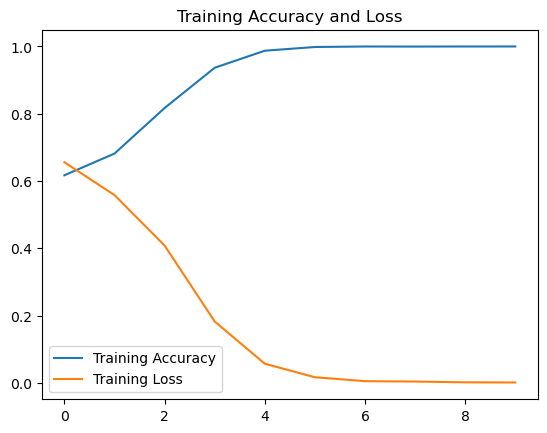

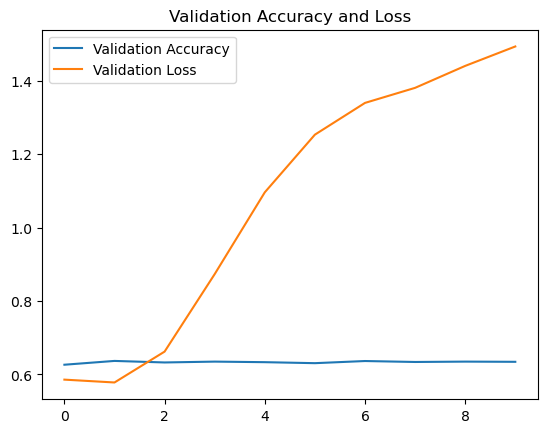

In [55]:
from tensorflow import keras
from keras.callbacks import History

history = History()
epochs = 10

model = keras.Sequential([
    keras.layers.Conv1D(64, kernel_size = 3, activation = "relu", input_shape = (train_inputs.shape[1], 1)),
    keras.layers.MaxPooling1D(pool_size = 2),
    keras.layers.Conv1D(32, kernel_size = 3, activation = "relu"),
    keras.layers.MaxPooling1D(pool_size = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(train_outputs.shape[1], activation = "sigmoid"),
])

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["binary_accuracy"])
model.fit(train_inputs, train_outputs, epochs = epochs, batch_size = 16, callbacks = [history], validation_data = (test_inputs, test_outputs))

loss, accuracy = model.evaluate(test_inputs, test_outputs)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
plot_history(epochs, history, "binary_accuracy")

In [58]:
predictions = model.predict(test_inputs)
predicted_labels = unpack(decode(predictions))
actual_labels = unpack(decode(test_outputs))
print("Predicted Labels:", predicted_labels[0])
print("Actual Labels:", actual_labels[0])

8/8 [==============================] - 0s 11ms/step
Predicted Labels: [4.0, 67.0, 9.0, 8.0, 3.1, 2.4, 74.0, 12.0, 54.0, 1.4, 21.0, 51.0]
Actual Labels: [4.0, 112.0, 11.0, 7.7, 2.9, 1.9, 82.0, 19.0, 46.0, 1.3, 20.0, 42.0]


# Vector-Dense Network

Epoch 1/20
128/128 [==============================] - 3s 7ms/step - loss: 2556.4788 - accuracy: 0.2202 - val_loss: 2415.7351 - val_accuracy: 0.2467
Epoch 2/20
128/128 [==============================] - 1s 5ms/step - loss: 2376.7839 - accuracy: 0.3060 - val_loss: 2211.0544 - val_accuracy: 0.2731
Epoch 3/20
128/128 [==============================] - 1s 6ms/step - loss: 1986.0319 - accuracy: 0.4129 - val_loss: 1757.2174 - val_accuracy: 0.4626
Epoch 4/20
128/128 [==============================] - 1s 5ms/step - loss: 1483.0719 - accuracy: 0.4649 - val_loss: 1122.4569 - val_accuracy: 0.5551
Epoch 5/20
128/128 [==============================] - 1s 6ms/step - loss: 1004.8271 - accuracy: 0.5660 - val_loss: 796.3270 - val_accuracy: 0.5595
Epoch 6/20
128/128 [==============================] - 1s 8ms/step - loss: 631.2343 - accuracy: 0.6317 - val_loss: 449.4235 - val_accuracy: 0.6256
Epoch 7/20
128/128 [==============================] - 1s 6ms/step - loss: 375.4475 - accuracy: 0.6999 - val_loss: 2

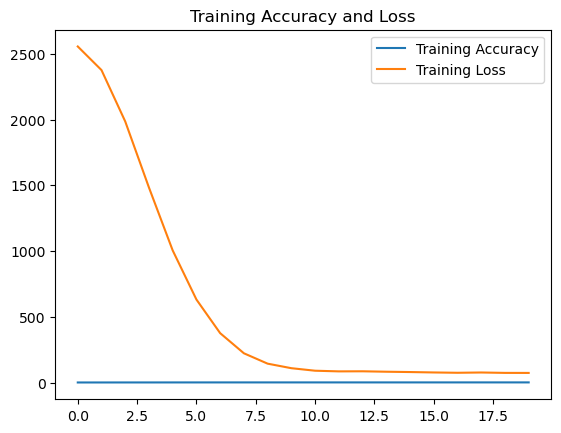

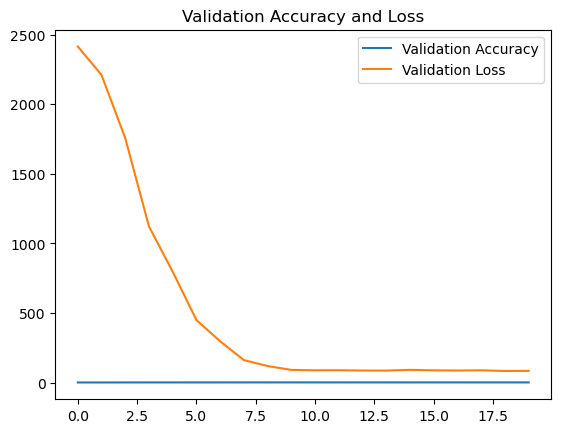

In [59]:
history = History()
epochs = 20

model = keras.Sequential([
    keras.layers.Dense(128, activation = "relu", input_shape = (train_features.shape[1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(train_labels.shape[1])
])

model.compile(optimizer = "adam", loss = "mse", metrics = ["accuracy"])

model.fit(train_features, train_labels, epochs = epochs, batch_size = 16, validation_data = (test_features, test_labels), callbacks = [history])

loss, accuracy = model.evaluate(test_features, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
plot_history(epochs, history, "accuracy")

In [60]:
predictions = model.predict(test_features)
predicted_labels = predictions
actual_labels = test_labels
print("Predicted Labels:", predicted_labels[0])
print("Actual Labels:", actual_labels[0])

8/8 [==============================] - 0s 2ms/step
Predicted Labels: [ 4.558047  94.89745   13.746864   8.290008   3.2512436  2.6647744
 83.12446   14.987949  48.171387   1.421891  23.391907  33.429523 ]
Actual Labels: [  4.  112.   11.    7.7   2.9   1.9  82.   19.   46.    1.3  20.   42. ]


# Vector-Recurrent Network

In [7]:
history = History()
epochs = 10

model = keras.Sequential([
    keras.layers.Embedding(input_dim = train_features.shape[1], output_dim = 64),
    keras.layers.GRU(256, return_sequences = True),
    keras.layers.SimpleRNN(128),
    keras.layers.Dense(padded_train_labels.shape[1], activation = "sigmoid")
])

model.compile(optimizer = "adam", loss = "mse", metrics = ["accuracy"])
model.fit(train_features, padded_train_labels, epochs = epochs, batch_size = 16, callbacks = [history], validation_data = (train_features, padded_train_labels))

loss, accuracy = model.evaluate(test_features, padded_test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
plot_history(epochs, history, "accuracy")

Epoch 1/10


KeyboardInterrupt: 

In [ ]:
predictions = model.predict(test_inputs)
predicted_labels = unpack(decode(predictions))
actual_labels = unpack(decode(test_outputs))
print("Predicted Labels:", predicted_labels[0])
print("Actual Labels:", actual_labels[0])

# Performance Evaluation

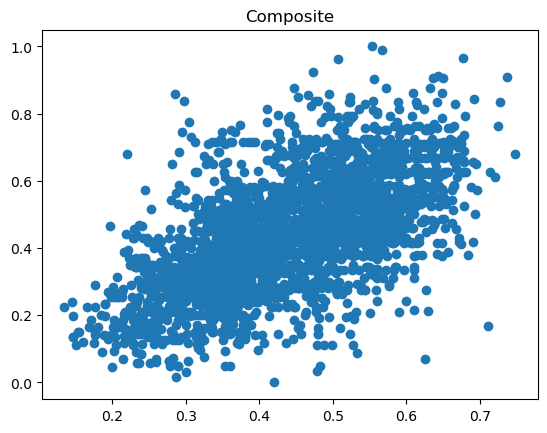

Correlation:  0.5925464374638654


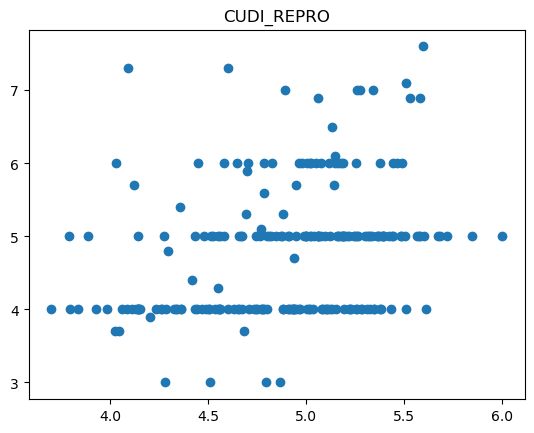

Correlation:  0.3091049340620066


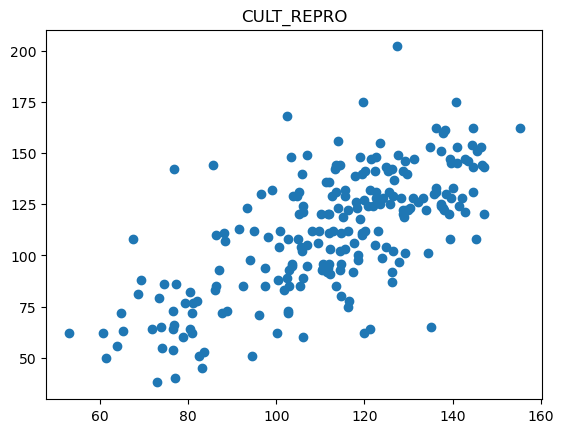

Correlation:  0.6846692259561675


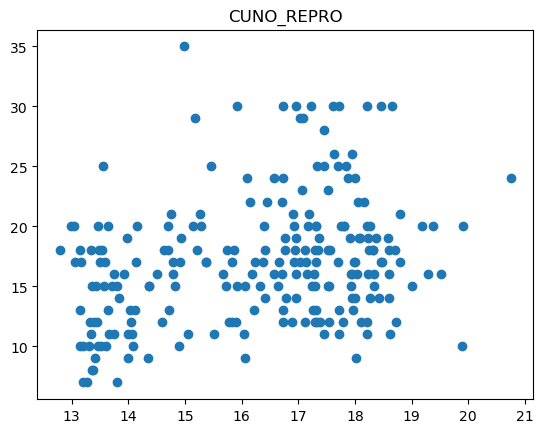

Correlation:  0.29565501532028066


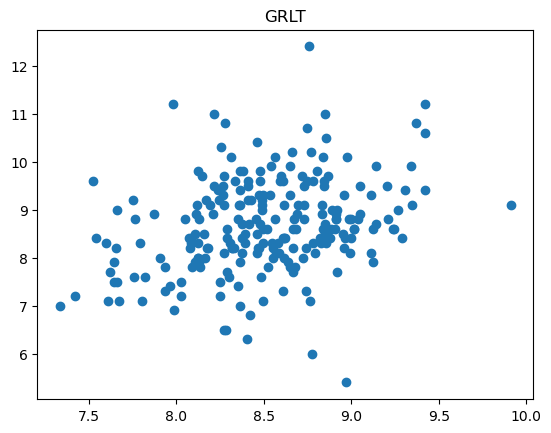

Correlation:  0.2985131254474999


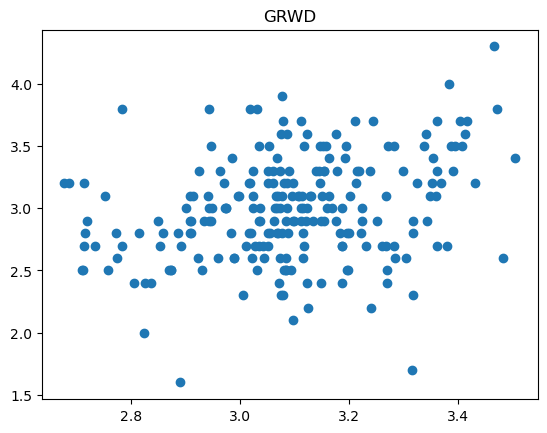

Correlation:  0.2895764820757262


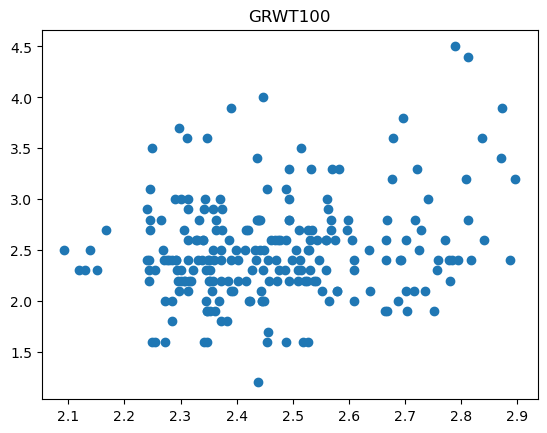

Correlation:  0.21743658290785675


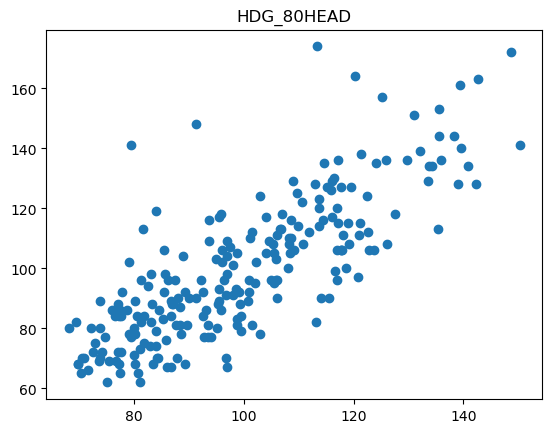

Correlation:  0.7985262903480094


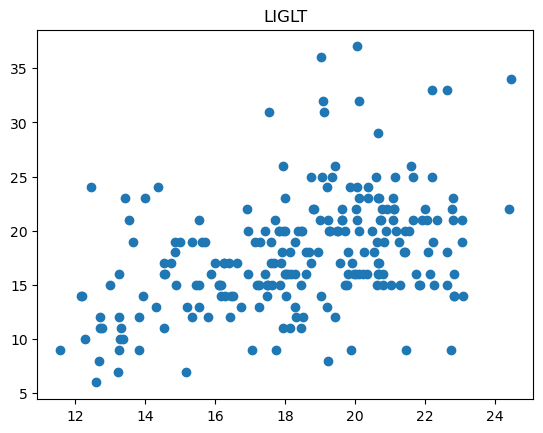

Correlation:  0.4193442525465494


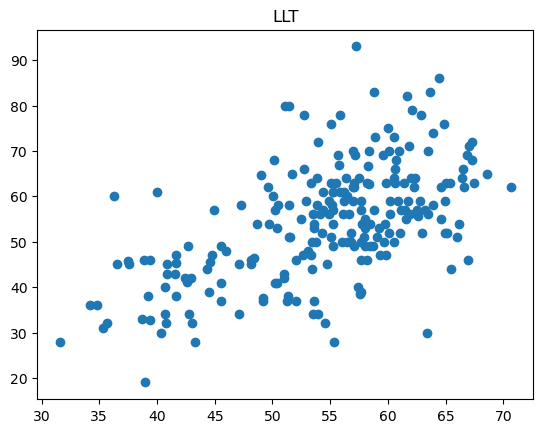

Correlation:  0.5748592066463203


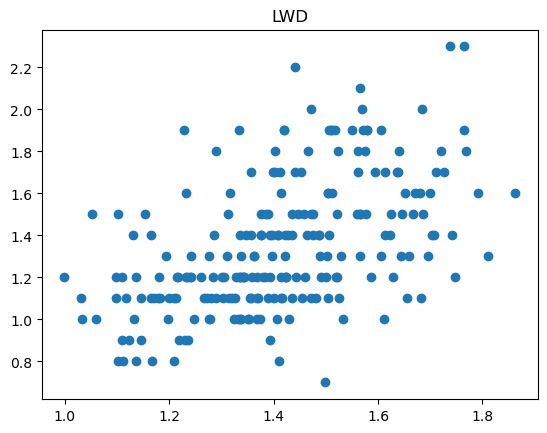

Correlation:  0.5214059519015992


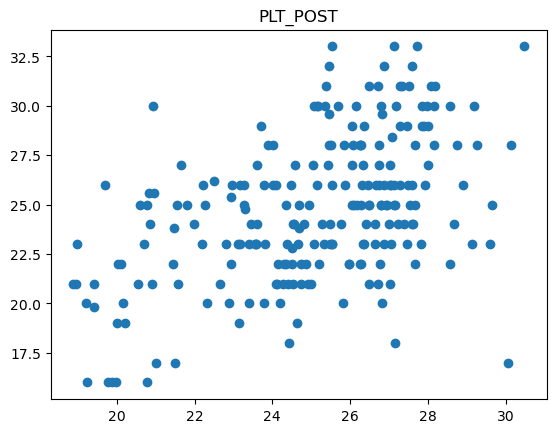

Correlation:  0.4863209742406415


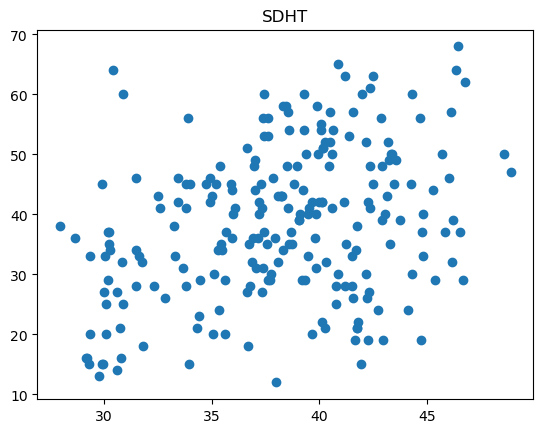

Correlation:  0.33287271527170925


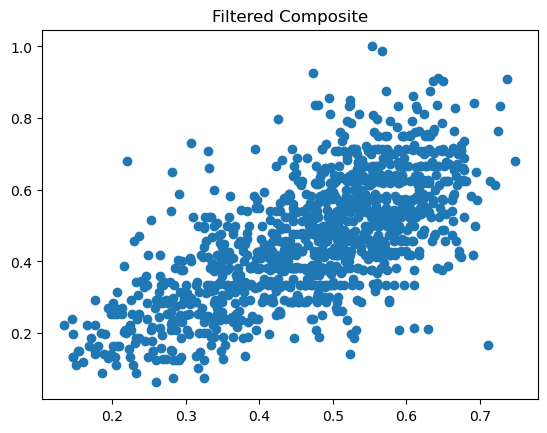

Correlation:  0.669844938879686


0.669844938879686

In [61]:
mins = []
maxs = []
for column in tdf.columns:
    mins.append(tdf[column].min())
    maxs.append(tdf[column].max())
    
normalize = lambda arr: [[(subarr[i] - mins[i])/(maxs[i] - mins[i]) for i in range(len(subarr))] for subarr in arr]
predicted_normals = normalize(predicted_labels)
actual_normals = normalize(actual_labels)

def plot(title, x_values, y_values):
    plt.title(title)
    plt.scatter(x_values, y_values)
    plt.show()
    corr = pd.Series(x_values).corr(pd.Series(y_values))
    print("Correlation: ", corr)
    return corr

plot("Composite", flatten(predicted_normals), flatten(actual_normals))

corrs = []
for column in tdf.columns:
    iloc = tdf.columns.get_loc(column)
    corrs.append(plot(column, take(predicted_labels, iloc), take(actual_labels, iloc)))

top_take = 5
top_corrs_indices = np.argsort(np.array(corrs))[-top_take:]
x_values = []
y_values = []
for top_index in top_corrs_indices:
    x_values += take(predicted_normals, top_index)
    y_values += take(actual_normals, top_index)
plot("Filtered Composite", x_values, y_values)